In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json
import fasttext

In [2]:
with open(r"data/ATE_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/ATE_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/ATE_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
model = fasttext.load_model("cc.en.300.bin")

In [4]:
word_embedding = model.get_word_vector('hello')
print(word_embedding)

[ 1.57576188e-01  4.37820926e-02 -4.51271934e-03  6.65931404e-02
  7.70346820e-02  4.85855248e-03  8.19822028e-03  6.52402919e-03
  9.25899856e-03  3.53899002e-02 -2.31395271e-02 -4.91807126e-02
 -8.32642540e-02  1.56014524e-02  2.54856616e-01  3.45423706e-02
 -1.07451361e-02 -7.80188590e-02 -7.08099529e-02  7.62385577e-02
 -6.09613657e-02  4.48625796e-02 -7.29744136e-02  1.30583309e-02
  3.14881057e-02 -3.10055036e-02  1.66004002e-02  1.74405202e-02
 -7.35838860e-02  1.18252613e-01 -1.21330231e-01 -4.09253240e-02
  2.93969568e-02  4.84445989e-02 -1.33816330e-02 -1.74765270e-02
  7.51308873e-02  9.97046307e-02 -4.00476977e-02  4.05735290e-03
 -7.21896589e-02 -4.43356819e-02 -1.22628408e-03  7.56693557e-02
  3.98401320e-02  3.22643593e-02  1.95914153e-02  4.68016043e-02
 -1.46228177e-02  1.12967767e-01  3.15065160e-02 -1.02312110e-01
  1.58124104e-01 -2.76147053e-02 -3.39851156e-02 -1.77006852e-02
 -5.73529862e-04  1.10789239e-01 -1.64533369e-02 -3.14955460e-03
 -4.22914140e-02  1.11429

In [5]:
def convert_data_to_tensors(data, model):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
                embedding.append(model.get_word_vector(word))
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 83 # maximum length of word in 1 text 
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * len(model.get_word_vector("Hello"))] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    input_ids = torch.tensor(padded_embeddings)

    return input_ids

In [6]:

x_train = convert_data_to_tensors(train_data, model)
x_val = convert_data_to_tensors(val_data, model)
x_test = convert_data_to_tensors(test_data, model)

/tmp/ipykernel_31867/1681424001.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings)


In [7]:
x_train.size()

torch.Size([906, 83, 300])

In [8]:
def convert_labels_to_fixed_length(labels, max_length):
    new_list=[]
    label_to_index = {'B': 0, 'I': 1, 'O': 2,'<pad>':3}
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 3
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 83
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [9]:
y_train.size()

torch.Size([906, 83])

In [10]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [11]:


# Assuming you have your data loaded into variables `X_train`, `y_train`, `X_val`, `y_val`
# X_train: (906, 83, 300), y_train: (906, 83, 3)
# X_val: (val_size, 83, 300), y_val: (val_size, 83, 3)

# Convert data to PyTorch tensors
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class LSTMTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMTagger, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 4
learning_rate = 0.001
num_epochs = 150
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = LSTMTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_31867/2600715320.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_31867/2600715320.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_31867/2600715320.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_31867/2600715320.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/150, Train Loss: 1.2207509577274323, Val Loss: 1.0140777826309204, Val F1: 0.31532441302701336, Train F1: 0.2414952388833121


  1%|█▉                                                                                                                                                | 2/150 [00:01<01:59,  1.24it/s]

Epoch 2/150, Train Loss: 0.7580630257725716, Val Loss: 0.5053249597549438, Val F1: 0.31532441302701336, Train F1: 0.2945257784315076


  2%|██▉                                                                                                                                               | 3/150 [00:02<01:54,  1.29it/s]

Epoch 3/150, Train Loss: 0.526781402528286, Val Loss: 0.4763270318508148, Val F1: 0.31532441302701336, Train F1: 0.30441720967723135


  3%|███▉                                                                                                                                              | 4/150 [00:03<01:47,  1.36it/s]

Epoch 4/150, Train Loss: 0.47035473212599754, Val Loss: 0.4197661280632019, Val F1: 0.31532441302701336, Train F1: 0.3041790591994953


  3%|████▊                                                                                                                                             | 5/150 [00:03<01:44,  1.39it/s]

Epoch 5/150, Train Loss: 0.4266779087483883, Val Loss: 0.41026750206947327, Val F1: 0.31532441302701336, Train F1: 0.3051720930154448


  4%|█████▊                                                                                                                                            | 6/150 [00:04<01:40,  1.43it/s]

Epoch 6/150, Train Loss: 0.4107816815376282, Val Loss: 0.3879534602165222, Val F1: 0.31532441302701336, Train F1: 0.3049969145776888


  5%|██████▊                                                                                                                                           | 7/150 [00:05<01:38,  1.45it/s]

Epoch 7/150, Train Loss: 0.4125964939594269, Val Loss: 0.3743475377559662, Val F1: 0.31532441302701336, Train F1: 0.30390813888254087


  5%|███████▊                                                                                                                                          | 8/150 [00:05<01:36,  1.47it/s]

Epoch 8/150, Train Loss: 0.39332298189401627, Val Loss: 0.36362606287002563, Val F1: 0.31532441302701336, Train F1: 0.30396157750190483


  6%|████████▊                                                                                                                                         | 9/150 [00:06<01:37,  1.45it/s]

Epoch 9/150, Train Loss: 0.373802799731493, Val Loss: 0.34753596782684326, Val F1: 0.31532441302701336, Train F1: 0.30447348518774453


  7%|█████████▋                                                                                                                                       | 10/150 [00:07<01:36,  1.44it/s]

Epoch 10/150, Train Loss: 0.35214972868561745, Val Loss: 0.3341331481933594, Val F1: 0.31532441302701336, Train F1: 0.3052015983276818


  7%|██████████▋                                                                                                                                      | 11/150 [00:08<01:46,  1.31it/s]

Epoch 11/150, Train Loss: 0.3414227366447449, Val Loss: 0.32117515802383423, Val F1: 0.3154040404040404, Train F1: 0.3056348140864004


  8%|███████████▌                                                                                                                                     | 12/150 [00:08<01:43,  1.34it/s]

Epoch 12/150, Train Loss: 0.3282932974398136, Val Loss: 0.30900296568870544, Val F1: 0.3199281524515169, Train F1: 0.308673786618959


  9%|████████████▌                                                                                                                                    | 13/150 [00:09<01:39,  1.37it/s]

Epoch 13/150, Train Loss: 0.32336411252617836, Val Loss: 0.2954227328300476, Val F1: 0.32653635429220657, Train F1: 0.31087107932269004


  9%|█████████████▌                                                                                                                                   | 14/150 [00:10<01:37,  1.39it/s]

Epoch 14/150, Train Loss: 0.3059863932430744, Val Loss: 0.2819949686527252, Val F1: 0.3286172706555496, Train F1: 0.32174626876008644


 10%|██████████████▌                                                                                                                                  | 15/150 [00:10<01:35,  1.41it/s]

Epoch 15/150, Train Loss: 0.2967558391392231, Val Loss: 0.2706785202026367, Val F1: 0.3545478459135683, Train F1: 0.323829053913549


 11%|███████████████▍                                                                                                                                 | 16/150 [00:11<01:35,  1.40it/s]

Epoch 16/150, Train Loss: 0.28297938220202923, Val Loss: 0.25782015919685364, Val F1: 0.36966314276243967, Train F1: 0.3484357799126644


 11%|████████████████▍                                                                                                                                | 17/150 [00:12<01:35,  1.39it/s]

Epoch 17/150, Train Loss: 0.262036070227623, Val Loss: 0.24375274777412415, Val F1: 0.38788582577518244, Train F1: 0.3923726910564695


 12%|█████████████████▍                                                                                                                               | 18/150 [00:12<01:33,  1.42it/s]

Epoch 18/150, Train Loss: 0.264790553599596, Val Loss: 0.23485694825649261, Val F1: 0.4815686662131997, Train F1: 0.42306399024144475


 13%|██████████████████▎                                                                                                                              | 19/150 [00:13<01:30,  1.44it/s]

Epoch 19/150, Train Loss: 0.24003727175295353, Val Loss: 0.22278477251529694, Val F1: 0.5282458582675262, Train F1: 0.5211015584583427


 13%|███████████████████▎                                                                                                                             | 20/150 [00:14<01:28,  1.46it/s]

Epoch 20/150, Train Loss: 0.22871792130172253, Val Loss: 0.2116355448961258, Val F1: 0.5775057030096581, Train F1: 0.5148552410752503


 14%|████████████████████▎                                                                                                                            | 21/150 [00:14<01:27,  1.47it/s]

Epoch 21/150, Train Loss: 0.21814021840691566, Val Loss: 0.20752301812171936, Val F1: 0.5743039443019907, Train F1: 0.5909717017522254


 15%|█████████████████████▎                                                                                                                           | 22/150 [00:15<01:27,  1.47it/s]

Epoch 22/150, Train Loss: 0.21890486404299736, Val Loss: 0.1993546485900879, Val F1: 0.6061332193651235, Train F1: 0.6114780927068043


 15%|██████████████████████▏                                                                                                                          | 23/150 [00:16<01:28,  1.44it/s]

Epoch 23/150, Train Loss: 0.22494245134294033, Val Loss: 0.19826693832874298, Val F1: 0.7260099417218515, Train F1: 0.6162777598763566


 16%|███████████████████████▏                                                                                                                         | 24/150 [00:17<01:27,  1.44it/s]

Epoch 24/150, Train Loss: 0.21440582908689976, Val Loss: 0.18882106244564056, Val F1: 0.7014915548503559, Train F1: 0.647461763797486


 17%|████████████████████████▏                                                                                                                        | 25/150 [00:17<01:28,  1.42it/s]

Epoch 25/150, Train Loss: 0.20176729932427406, Val Loss: 0.18374449014663696, Val F1: 0.6946199994239043, Train F1: 0.6810686861480593


 17%|█████████████████████████▏                                                                                                                       | 26/150 [00:18<01:33,  1.33it/s]

Epoch 26/150, Train Loss: 0.18785596452653408, Val Loss: 0.18166998028755188, Val F1: 0.6825467383708187, Train F1: 0.6649343932870784


 18%|██████████████████████████                                                                                                                       | 27/150 [00:19<01:31,  1.34it/s]

Epoch 27/150, Train Loss: 0.18858822993934155, Val Loss: 0.1779356300830841, Val F1: 0.7325315079728583, Train F1: 0.6843251017451437


 19%|███████████████████████████                                                                                                                      | 28/150 [00:20<01:32,  1.32it/s]

Epoch 28/150, Train Loss: 0.18426303938031197, Val Loss: 0.17493557929992676, Val F1: 0.7312820859612946, Train F1: 0.7068784274307606


 19%|████████████████████████████                                                                                                                     | 29/150 [00:20<01:29,  1.35it/s]

Epoch 29/150, Train Loss: 0.17982139997184277, Val Loss: 0.17342007160186768, Val F1: 0.7480819452708664, Train F1: 0.7282493249530009


 20%|█████████████████████████████                                                                                                                    | 30/150 [00:21<01:31,  1.30it/s]

Epoch 30/150, Train Loss: 0.17448662035167217, Val Loss: 0.16950616240501404, Val F1: 0.7321387482445649, Train F1: 0.7272603137152147


 21%|█████████████████████████████▉                                                                                                                   | 31/150 [00:22<01:31,  1.31it/s]

Epoch 31/150, Train Loss: 0.17287749983370304, Val Loss: 0.16767744719982147, Val F1: 0.7285802359167035, Train F1: 0.722461559073758


 21%|██████████████████████████████▉                                                                                                                  | 32/150 [00:23<01:28,  1.34it/s]

Epoch 32/150, Train Loss: 0.1733139269053936, Val Loss: 0.16637225449085236, Val F1: 0.7567363571717015, Train F1: 0.7298345577306816


 22%|███████████████████████████████▉                                                                                                                 | 33/150 [00:23<01:25,  1.36it/s]

Epoch 33/150, Train Loss: 0.18072781525552273, Val Loss: 0.17368243634700775, Val F1: 0.7692039602005826, Train F1: 0.7301194739546808


 23%|████████████████████████████████▊                                                                                                                | 34/150 [00:24<01:23,  1.39it/s]

Epoch 34/150, Train Loss: 0.16864242311567068, Val Loss: 0.16557498276233673, Val F1: 0.7543361357423047, Train F1: 0.7332244079889545


 23%|█████████████████████████████████▊                                                                                                               | 35/150 [00:25<01:21,  1.41it/s]

Epoch 35/150, Train Loss: 0.17653953097760677, Val Loss: 0.16233845055103302, Val F1: 0.7483090190799052, Train F1: 0.7350029756917431


 24%|██████████████████████████████████▊                                                                                                              | 36/150 [00:25<01:20,  1.41it/s]

Epoch 36/150, Train Loss: 0.1626998968422413, Val Loss: 0.16270478069782257, Val F1: 0.7438715766081377, Train F1: 0.7616476486476826


 25%|███████████████████████████████████▊                                                                                                             | 37/150 [00:26<01:18,  1.43it/s]

Epoch 37/150, Train Loss: 0.1696567889302969, Val Loss: 0.16100241243839264, Val F1: 0.7575129610410634, Train F1: 0.7392451093688924


 25%|████████████████████████████████████▋                                                                                                            | 38/150 [00:27<01:18,  1.43it/s]

Epoch 38/150, Train Loss: 0.16431144811213017, Val Loss: 0.15986421704292297, Val F1: 0.7437976168484287, Train F1: 0.7546674208213611


 26%|█████████████████████████████████████▋                                                                                                           | 39/150 [00:28<01:18,  1.41it/s]

Epoch 39/150, Train Loss: 0.15091489255428314, Val Loss: 0.15988390147686005, Val F1: 0.757360609939563, Train F1: 0.7710503123023894


 27%|██████████████████████████████████████▋                                                                                                          | 40/150 [00:28<01:17,  1.42it/s]

Epoch 40/150, Train Loss: 0.15657933056354523, Val Loss: 0.1599712073802948, Val F1: 0.7769454867062736, Train F1: 0.7525929671032425


 27%|███████████████████████████████████████▋                                                                                                         | 41/150 [00:29<01:16,  1.43it/s]

Epoch 41/150, Train Loss: 0.14925341587513685, Val Loss: 0.155780628323555, Val F1: 0.7796460100808749, Train F1: 0.7885482992051787


 28%|████████████████████████████████████████▌                                                                                                        | 42/150 [00:30<01:15,  1.44it/s]

Epoch 42/150, Train Loss: 0.1677191499620676, Val Loss: 0.1694011688232422, Val F1: 0.7817296411048146, Train F1: 0.7795682653722744


 29%|█████████████████████████████████████████▌                                                                                                       | 43/150 [00:30<01:14,  1.43it/s]

Epoch 43/150, Train Loss: 0.1627788282930851, Val Loss: 0.15565428137779236, Val F1: 0.7550610220012715, Train F1: 0.7721178694248046


 29%|██████████████████████████████████████████▌                                                                                                      | 44/150 [00:31<01:14,  1.43it/s]

Epoch 44/150, Train Loss: 0.15010346472263336, Val Loss: 0.15899068117141724, Val F1: 0.7199831411026537, Train F1: 0.7981430788509277


 30%|███████████████████████████████████████████▌                                                                                                     | 45/150 [00:32<01:13,  1.43it/s]

Epoch 45/150, Train Loss: 0.15090692415833473, Val Loss: 0.1542208343744278, Val F1: 0.7877191254103014, Train F1: 0.7821528027466731


 31%|████████████████████████████████████████████▍                                                                                                    | 46/150 [00:32<01:12,  1.44it/s]

Epoch 46/150, Train Loss: 0.1464063599705696, Val Loss: 0.15222646296024323, Val F1: 0.7771377059189258, Train F1: 0.7971266266051326


 31%|█████████████████████████████████████████████▍                                                                                                   | 47/150 [00:33<01:10,  1.45it/s]

Epoch 47/150, Train Loss: 0.14941923506557941, Val Loss: 0.15130434930324554, Val F1: 0.7726721467624903, Train F1: 0.8095280838761191


 32%|██████████████████████████████████████████████▍                                                                                                  | 48/150 [00:34<01:09,  1.46it/s]

Epoch 48/150, Train Loss: 0.1420779787003994, Val Loss: 0.15198196470737457, Val F1: 0.7791629421075728, Train F1: 0.8064477432978715


 33%|███████████████████████████████████████████████▎                                                                                                 | 49/150 [00:34<01:08,  1.47it/s]

Epoch 49/150, Train Loss: 0.13680083118379116, Val Loss: 0.15059614181518555, Val F1: 0.7681455665836162, Train F1: 0.8177621434133397


 33%|████████████████████████████████████████████████▎                                                                                                | 50/150 [00:35<01:08,  1.47it/s]

Epoch 50/150, Train Loss: 0.13543828018009663, Val Loss: 0.15108616650104523, Val F1: 0.7662618792642433, Train F1: 0.8219913158790961


 34%|█████████████████████████████████████████████████▎                                                                                               | 51/150 [00:36<01:07,  1.46it/s]

Epoch 51/150, Train Loss: 0.1360023571178317, Val Loss: 0.15144465863704681, Val F1: 0.7629172700480007, Train F1: 0.8179281437604378


 35%|██████████████████████████████████████████████████▎                                                                                              | 52/150 [00:37<01:07,  1.46it/s]

Epoch 52/150, Train Loss: 0.13495772890746593, Val Loss: 0.15149427950382233, Val F1: 0.7658861521788474, Train F1: 0.8266385584038657


 35%|███████████████████████████████████████████████████▏                                                                                             | 53/150 [00:37<01:07,  1.45it/s]

Epoch 53/150, Train Loss: 0.13055641576647758, Val Loss: 0.1481984257698059, Val F1: 0.7820036490005581, Train F1: 0.8254367845437232


 36%|████████████████████████████████████████████████████▏                                                                                            | 54/150 [00:38<01:05,  1.46it/s]

Epoch 54/150, Train Loss: 0.13506621681153774, Val Loss: 0.15331411361694336, Val F1: 0.7934104107000081, Train F1: 0.816777827738397


 37%|█████████████████████████████████████████████████████▏                                                                                           | 55/150 [00:39<01:04,  1.47it/s]

Epoch 55/150, Train Loss: 0.13820846751332283, Val Loss: 0.15205860137939453, Val F1: 0.7747596859051967, Train F1: 0.8150342344405705


 37%|██████████████████████████████████████████████████████▏                                                                                          | 56/150 [00:39<01:05,  1.44it/s]

Epoch 56/150, Train Loss: 0.1339363306760788, Val Loss: 0.15396636724472046, Val F1: 0.7547480867247667, Train F1: 0.8213027714775425


 38%|███████████████████████████████████████████████████████                                                                                          | 57/150 [00:40<01:03,  1.45it/s]

Epoch 57/150, Train Loss: 0.12601025123149157, Val Loss: 0.14933009445667267, Val F1: 0.7971968247569472, Train F1: 0.816272676323694


 39%|████████████████████████████████████████████████████████                                                                                         | 58/150 [00:41<01:02,  1.46it/s]

Epoch 58/150, Train Loss: 0.12247682362794876, Val Loss: 0.14780132472515106, Val F1: 0.7996955075328201, Train F1: 0.8371453137843258


 39%|█████████████████████████████████████████████████████████                                                                                        | 59/150 [00:41<01:02,  1.46it/s]

Epoch 59/150, Train Loss: 0.11789120454341173, Val Loss: 0.14823730289936066, Val F1: 0.7869895035153748, Train F1: 0.8452598115164754


 40%|██████████████████████████████████████████████████████████                                                                                       | 60/150 [00:42<01:01,  1.46it/s]

Epoch 60/150, Train Loss: 0.1251339167356491, Val Loss: 0.1491168737411499, Val F1: 0.7999888012823262, Train F1: 0.8459456503538756


 41%|██████████████████████████████████████████████████████████▉                                                                                      | 61/150 [00:43<01:00,  1.46it/s]

Epoch 61/150, Train Loss: 0.12019066978245974, Val Loss: 0.1488894373178482, Val F1: 0.7749126026294743, Train F1: 0.821710544061409


 41%|███████████████████████████████████████████████████████████▉                                                                                     | 62/150 [00:43<01:00,  1.45it/s]

Epoch 62/150, Train Loss: 0.11492125783115625, Val Loss: 0.15117676556110382, Val F1: 0.764188038560803, Train F1: 0.8506669760115999


 42%|████████████████████████████████████████████████████████████▉                                                                                    | 63/150 [00:44<00:59,  1.45it/s]

Epoch 63/150, Train Loss: 0.11785879079252481, Val Loss: 0.15271301567554474, Val F1: 0.7524031794290121, Train F1: 0.8248832682285814


 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 64/150 [00:45<00:58,  1.46it/s]

Epoch 64/150, Train Loss: 0.11628883518278599, Val Loss: 0.14951469004154205, Val F1: 0.7785446845423615, Train F1: 0.8330979251551169


 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 65/150 [00:45<00:57,  1.47it/s]

Epoch 65/150, Train Loss: 0.11651079263538122, Val Loss: 0.15386958420276642, Val F1: 0.7943799773480191, Train F1: 0.8505028004348663


 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 66/150 [00:46<00:57,  1.46it/s]

Epoch 66/150, Train Loss: 0.1151498518884182, Val Loss: 0.15018711984157562, Val F1: 0.7652046993563381, Train F1: 0.8536993939030044


 45%|████████████████████████████████████████████████████████████████▊                                                                                | 67/150 [00:47<00:56,  1.46it/s]

Epoch 67/150, Train Loss: 0.1151017565280199, Val Loss: 0.1473410725593567, Val F1: 0.7956740376624309, Train F1: 0.8473943266876413


 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 68/150 [00:48<00:56,  1.45it/s]

Epoch 68/150, Train Loss: 0.10450037755072117, Val Loss: 0.14968626201152802, Val F1: 0.7736569104990156, Train F1: 0.8559100237986628


 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 69/150 [00:48<00:55,  1.46it/s]

Epoch 69/150, Train Loss: 0.11342804599553347, Val Loss: 0.15041448175907135, Val F1: 0.7684596728292542, Train F1: 0.8598553663639861


 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 70/150 [00:49<00:54,  1.46it/s]

Epoch 70/150, Train Loss: 0.11228082608431578, Val Loss: 0.14924417436122894, Val F1: 0.7787586662146747, Train F1: 0.8645321212119328


 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 71/150 [00:50<00:54,  1.44it/s]

Epoch 71/150, Train Loss: 0.10503636486828327, Val Loss: 0.1488642394542694, Val F1: 0.786129991098708, Train F1: 0.8704333022967478


 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 72/150 [00:51<00:59,  1.32it/s]

Epoch 72/150, Train Loss: 0.10096604563295841, Val Loss: 0.15193861722946167, Val F1: 0.7848550692134039, Train F1: 0.8726027055300974


 49%|██████████████████████████████████████████████████████████████████████▌                                                                          | 73/150 [00:51<01:01,  1.25it/s]

Epoch 73/150, Train Loss: 0.09614400239661336, Val Loss: 0.1505870372056961, Val F1: 0.7866285238447482, Train F1: 0.8796579889939652


 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 74/150 [00:52<01:03,  1.20it/s]

Epoch 74/150, Train Loss: 0.09584242943674326, Val Loss: 0.15028834342956543, Val F1: 0.7960343247359128, Train F1: 0.8818516629533752


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 75/150 [00:53<01:03,  1.17it/s]

Epoch 75/150, Train Loss: 0.10096627194434404, Val Loss: 0.14979512989521027, Val F1: 0.7911607119120401, Train F1: 0.8854825165527657


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 76/150 [00:54<01:04,  1.15it/s]

Epoch 76/150, Train Loss: 0.09427836164832115, Val Loss: 0.15195918083190918, Val F1: 0.7881851732583711, Train F1: 0.8891643785854255


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 77/150 [00:55<01:03,  1.14it/s]

Epoch 77/150, Train Loss: 0.09336028294637799, Val Loss: 0.15921686589717865, Val F1: 0.7712544355804738, Train F1: 0.8774742963148765


 52%|███████████████████████████████████████████████████████████████████████████▍                                                                     | 78/150 [00:56<01:03,  1.13it/s]

Epoch 78/150, Train Loss: 0.10174743179231882, Val Loss: 0.1529020369052887, Val F1: 0.7903194824963818, Train F1: 0.8815475989365046


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 79/150 [00:57<01:03,  1.12it/s]

Epoch 79/150, Train Loss: 0.09888072591274977, Val Loss: 0.15979719161987305, Val F1: 0.7805672261550874, Train F1: 0.8837102986515074


 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 80/150 [00:58<01:02,  1.12it/s]

Epoch 80/150, Train Loss: 0.10002489574253559, Val Loss: 0.15125113725662231, Val F1: 0.7823774410096315, Train F1: 0.871974619356286


 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 81/150 [00:59<01:01,  1.12it/s]

Epoch 81/150, Train Loss: 0.0997498081997037, Val Loss: 0.15611302852630615, Val F1: 0.781016790764539, Train F1: 0.8833358593965034


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                 | 82/150 [01:00<01:00,  1.11it/s]

Epoch 82/150, Train Loss: 0.11064159963279963, Val Loss: 0.15726543962955475, Val F1: 0.764777159899111, Train F1: 0.8660046354543492


 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                | 83/150 [01:00<01:00,  1.12it/s]

Epoch 83/150, Train Loss: 0.08877893537282944, Val Loss: 0.16340290009975433, Val F1: 0.744973369892195, Train F1: 0.8864588768555433


 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 84/150 [01:01<00:59,  1.12it/s]

Epoch 84/150, Train Loss: 0.08924949448555708, Val Loss: 0.1574839949607849, Val F1: 0.783826672978129, Train F1: 0.8892767413017193


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 85/150 [01:02<00:58,  1.11it/s]

Epoch 85/150, Train Loss: 0.08684604614973068, Val Loss: 0.1574639528989792, Val F1: 0.7851360594633192, Train F1: 0.8991314215565868


 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                             | 86/150 [01:03<00:57,  1.11it/s]

Epoch 86/150, Train Loss: 0.0827006371691823, Val Loss: 0.1578577756881714, Val F1: 0.7882903520249224, Train F1: 0.9087858276237735


 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 87/150 [01:04<00:56,  1.11it/s]

Epoch 87/150, Train Loss: 0.07770476816222072, Val Loss: 0.1590503305196762, Val F1: 0.7871499169213014, Train F1: 0.9129086022398074


 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 88/150 [01:05<00:56,  1.10it/s]

Epoch 88/150, Train Loss: 0.07565472088754177, Val Loss: 0.16346624493598938, Val F1: 0.7886979913392369, Train F1: 0.9115857114193178


 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 89/150 [01:06<00:55,  1.10it/s]

Epoch 89/150, Train Loss: 0.07889346871525049, Val Loss: 0.160421684384346, Val F1: 0.7809791158004055, Train F1: 0.9149366815013732


 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 90/150 [01:07<00:55,  1.09it/s]

Epoch 90/150, Train Loss: 0.07184825371950865, Val Loss: 0.19320742785930634, Val F1: 0.7099430356388773, Train F1: 0.9200628236153984


 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                         | 91/150 [01:08<00:54,  1.08it/s]

Epoch 91/150, Train Loss: 0.08214859385043383, Val Loss: 0.16780942678451538, Val F1: 0.7589345808475633, Train F1: 0.9011137765178527


 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 92/150 [01:09<00:53,  1.08it/s]

Epoch 92/150, Train Loss: 0.07137247966602445, Val Loss: 0.16443872451782227, Val F1: 0.7762424968421385, Train F1: 0.9286923867610387


 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 93/150 [01:10<00:53,  1.07it/s]

Epoch 93/150, Train Loss: 0.0700431177392602, Val Loss: 0.17264167964458466, Val F1: 0.7769152533269715, Train F1: 0.9267742888065384


 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 94/150 [01:10<00:51,  1.09it/s]

Epoch 94/150, Train Loss: 0.07065458875149488, Val Loss: 0.17220057547092438, Val F1: 0.7724013234248526, Train F1: 0.9290838652592892


 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 95/150 [01:11<00:50,  1.09it/s]

Epoch 95/150, Train Loss: 0.06863862089812756, Val Loss: 0.18248628079891205, Val F1: 0.7296297101358586, Train F1: 0.9292740311265857


 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 96/150 [01:12<00:50,  1.07it/s]

Epoch 96/150, Train Loss: 0.0689579313620925, Val Loss: 0.183488130569458, Val F1: 0.7352426731923324, Train F1: 0.9236373303606809


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 97/150 [01:13<00:51,  1.04it/s]

Epoch 97/150, Train Loss: 0.06696705147624016, Val Loss: 0.17131422460079193, Val F1: 0.768502068830656, Train F1: 0.9260153071002226


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 98/150 [01:15<00:54,  1.05s/it]

Epoch 98/150, Train Loss: 0.06312624830752611, Val Loss: 0.17791402339935303, Val F1: 0.7712217229855848, Train F1: 0.937159358506204


 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 99/150 [01:16<00:58,  1.15s/it]

Epoch 99/150, Train Loss: 0.06230591982603073, Val Loss: 0.1748627871274948, Val F1: 0.76759014301288, Train F1: 0.9365150991152702


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 100/150 [01:18<01:03,  1.27s/it]

Epoch 100/150, Train Loss: 0.06191835831850767, Val Loss: 0.1776653230190277, Val F1: 0.7550747146920292, Train F1: 0.9416128416446566


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 101/150 [01:19<01:02,  1.27s/it]

Epoch 101/150, Train Loss: 0.058235469507053494, Val Loss: 0.18218110501766205, Val F1: 0.759397744670305, Train F1: 0.9451883564561295


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 102/150 [01:20<00:57,  1.20s/it]

Epoch 102/150, Train Loss: 0.05831305496394634, Val Loss: 0.1919538527727127, Val F1: 0.7589705381397205, Train F1: 0.936941968352642


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 103/150 [01:21<01:01,  1.30s/it]

Epoch 103/150, Train Loss: 0.06022179452702403, Val Loss: 0.18963931500911713, Val F1: 0.7517541120755338, Train F1: 0.9467056894887722


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 104/150 [01:23<01:00,  1.32s/it]

Epoch 104/150, Train Loss: 0.05571311293169856, Val Loss: 0.18930213153362274, Val F1: 0.7611302859385892, Train F1: 0.948198239355649


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 105/150 [01:24<00:58,  1.30s/it]

Epoch 105/150, Train Loss: 0.05317572271451354, Val Loss: 0.18656110763549805, Val F1: 0.7639881219006455, Train F1: 0.9490846628388115


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 106/150 [01:26<00:59,  1.35s/it]

Epoch 106/150, Train Loss: 0.05051967967301607, Val Loss: 0.198321133852005, Val F1: 0.7331832214740296, Train F1: 0.9522508769989763


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 107/150 [01:27<00:58,  1.36s/it]

Epoch 107/150, Train Loss: 0.04916730057448149, Val Loss: 0.1899644136428833, Val F1: 0.7581250298132098, Train F1: 0.9599981036786143


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 108/150 [01:28<00:52,  1.26s/it]

Epoch 108/150, Train Loss: 0.04947507428005338, Val Loss: 0.19501997530460358, Val F1: 0.7494245560490266, Train F1: 0.9618965424763107


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 109/150 [01:29<00:51,  1.25s/it]

Epoch 109/150, Train Loss: 0.04360376053955406, Val Loss: 0.19845323264598846, Val F1: 0.7523649222094813, Train F1: 0.9653208989447188


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 110/150 [01:30<00:49,  1.25s/it]

Epoch 110/150, Train Loss: 0.04543755669146776, Val Loss: 0.1999606043100357, Val F1: 0.7536252670337364, Train F1: 0.9646053999098922


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 111/150 [01:32<00:47,  1.21s/it]

Epoch 111/150, Train Loss: 0.045243033673614264, Val Loss: 0.20916932821273804, Val F1: 0.734714598656883, Train F1: 0.9596241868173089


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 112/150 [01:33<00:43,  1.16s/it]

Epoch 112/150, Train Loss: 0.04403902078047395, Val Loss: 0.2009563148021698, Val F1: 0.7571674456002815, Train F1: 0.9623610835641878


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 113/150 [01:34<00:41,  1.12s/it]

Epoch 113/150, Train Loss: 0.04755354160442948, Val Loss: 0.20562146604061127, Val F1: 0.7379997853514143, Train F1: 0.9640789981223908


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 114/150 [01:35<00:40,  1.13s/it]

Epoch 114/150, Train Loss: 0.04105395171791315, Val Loss: 0.20956028997898102, Val F1: 0.7331981078278584, Train F1: 0.9663663851156722


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 115/150 [01:36<00:41,  1.18s/it]

Epoch 115/150, Train Loss: 0.04282542155124247, Val Loss: 0.20706361532211304, Val F1: 0.7453004022544176, Train F1: 0.968187300332674


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 116/150 [01:37<00:40,  1.21s/it]

Epoch 116/150, Train Loss: 0.04235441796481609, Val Loss: 0.21276941895484924, Val F1: 0.7395753440468386, Train F1: 0.9650636774046465


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 117/150 [01:38<00:37,  1.15s/it]

Epoch 117/150, Train Loss: 0.0426559061743319, Val Loss: 0.20683445036411285, Val F1: 0.7584016536744741, Train F1: 0.9670053597606656


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 118/150 [01:39<00:36,  1.15s/it]

Epoch 118/150, Train Loss: 0.053465495351701975, Val Loss: 0.20396436750888824, Val F1: 0.7498025492007782, Train F1: 0.9521833221615557


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 119/150 [01:40<00:34,  1.11s/it]

Epoch 119/150, Train Loss: 0.04170670546591282, Val Loss: 0.21349777281284332, Val F1: 0.7502813630133716, Train F1: 0.9640030403254803


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 120/150 [01:42<00:32,  1.10s/it]

Epoch 120/150, Train Loss: 0.04526028875261545, Val Loss: 0.21964500844478607, Val F1: 0.7352936836783242, Train F1: 0.9595157280329064


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 121/150 [01:43<00:31,  1.10s/it]

Epoch 121/150, Train Loss: 0.041084792697802186, Val Loss: 0.2210865616798401, Val F1: 0.7369408876224052, Train F1: 0.9542835652660722


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 122/150 [01:44<00:29,  1.07s/it]

Epoch 122/150, Train Loss: 0.04790480202063918, Val Loss: 0.21570035815238953, Val F1: 0.7507307588569611, Train F1: 0.9440108730865996


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 123/150 [01:45<00:29,  1.09s/it]

Epoch 123/150, Train Loss: 0.039525453466922045, Val Loss: 0.21903462707996368, Val F1: 0.7309220247332268, Train F1: 0.967766080892076


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 124/150 [01:46<00:31,  1.20s/it]

Epoch 124/150, Train Loss: 0.043506893794983625, Val Loss: 0.2275175303220749, Val F1: 0.730073744472966, Train F1: 0.9623755804213908


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 125/150 [01:48<00:33,  1.35s/it]

Epoch 125/150, Train Loss: 0.03811674052849412, Val Loss: 0.21983081102371216, Val F1: 0.7403960095299705, Train F1: 0.9708956879225534


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/150 [01:49<00:32,  1.37s/it]

Epoch 126/150, Train Loss: 0.03657046123407781, Val Loss: 0.2228434532880783, Val F1: 0.7278651669450188, Train F1: 0.9703543513518601


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 127/150 [01:51<00:30,  1.34s/it]

Epoch 127/150, Train Loss: 0.041347311809659004, Val Loss: 0.22607257962226868, Val F1: 0.7393234554357816, Train F1: 0.9738828766828164


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 128/150 [01:52<00:31,  1.45s/it]

Epoch 128/150, Train Loss: 0.03770741634070873, Val Loss: 0.22749808430671692, Val F1: 0.7354295256100668, Train F1: 0.9668358310326656


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 129/150 [01:55<00:37,  1.79s/it]

Epoch 129/150, Train Loss: 0.03628270444460213, Val Loss: 0.25513729453086853, Val F1: 0.7183856007364047, Train F1: 0.974407571616748


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 130/150 [01:57<00:37,  1.85s/it]

Epoch 130/150, Train Loss: 0.03877041605301201, Val Loss: 0.24043987691402435, Val F1: 0.7332406203190359, Train F1: 0.9720337194775737


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 131/150 [02:00<00:43,  2.30s/it]

Epoch 131/150, Train Loss: 0.04489657562226057, Val Loss: 0.23215262591838837, Val F1: 0.7361048212444562, Train F1: 0.9640140891339773


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 132/150 [02:02<00:40,  2.26s/it]

Epoch 132/150, Train Loss: 0.029005797812715173, Val Loss: 0.23420162498950958, Val F1: 0.7362887357254267, Train F1: 0.9821998095240099


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 133/150 [02:05<00:42,  2.49s/it]

Epoch 133/150, Train Loss: 0.03375924029387534, Val Loss: 0.23564109206199646, Val F1: 0.7410401146699833, Train F1: 0.9720642444079144


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 134/150 [02:07<00:34,  2.15s/it]

Epoch 134/150, Train Loss: 0.030071184039115906, Val Loss: 0.24475422501564026, Val F1: 0.7229097291478377, Train F1: 0.9820001180279653


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 135/150 [02:08<00:27,  1.84s/it]

Epoch 135/150, Train Loss: 0.02931337500922382, Val Loss: 0.2450459748506546, Val F1: 0.7258784474981126, Train F1: 0.9809597449261663


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 136/150 [02:09<00:22,  1.62s/it]

Epoch 136/150, Train Loss: 0.02914000698365271, Val Loss: 0.24506214261054993, Val F1: 0.7327985727035609, Train F1: 0.979582636650242


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 137/150 [02:10<00:19,  1.50s/it]

Epoch 137/150, Train Loss: 0.027383808977901936, Val Loss: 0.24468526244163513, Val F1: 0.7322764320546632, Train F1: 0.9827905043398608


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/150 [02:11<00:16,  1.38s/it]

Epoch 138/150, Train Loss: 0.033212149515748024, Val Loss: 0.24571578204631805, Val F1: 0.7322445979881603, Train F1: 0.9758384601259016


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 139/150 [02:13<00:15,  1.41s/it]

Epoch 139/150, Train Loss: 0.027657897910103202, Val Loss: 0.250331848859787, Val F1: 0.7222918759665725, Train F1: 0.9828763742818607


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 140/150 [02:14<00:13,  1.39s/it]

Epoch 140/150, Train Loss: 0.027893936727195978, Val Loss: 0.25213149189949036, Val F1: 0.7339486489673818, Train F1: 0.9771612552567952


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 141/150 [02:16<00:13,  1.47s/it]

Epoch 141/150, Train Loss: 0.029558878857642412, Val Loss: 0.2618058919906616, Val F1: 0.7235266823634174, Train F1: 0.9827479325724086


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 142/150 [02:17<00:11,  1.41s/it]

Epoch 142/150, Train Loss: 0.025708398316055536, Val Loss: 0.25635528564453125, Val F1: 0.726423583141144, Train F1: 0.983281337949509


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 143/150 [02:18<00:09,  1.36s/it]

Epoch 143/150, Train Loss: 0.026815108954906464, Val Loss: 0.2508861720561981, Val F1: 0.7301006655472841, Train F1: 0.9828292169760545


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 144/150 [02:20<00:08,  1.35s/it]

Epoch 144/150, Train Loss: 0.0258929377887398, Val Loss: 0.25597742199897766, Val F1: 0.741151346164875, Train F1: 0.9815050587413832


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 145/150 [02:21<00:06,  1.29s/it]

Epoch 145/150, Train Loss: 0.023936644895002246, Val Loss: 0.25542977452278137, Val F1: 0.7202342713552152, Train F1: 0.9834366911195505


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 146/150 [02:22<00:05,  1.30s/it]

Epoch 146/150, Train Loss: 0.02324303286150098, Val Loss: 0.24954922497272491, Val F1: 0.7359126006529038, Train F1: 0.9864017395303115


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 147/150 [02:23<00:03,  1.28s/it]

Epoch 147/150, Train Loss: 0.023568519856780767, Val Loss: 0.26042288541793823, Val F1: 0.7356068436710524, Train F1: 0.9823196430114955


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 148/150 [02:25<00:02,  1.25s/it]

Epoch 148/150, Train Loss: 0.02403893764130771, Val Loss: 0.2613980174064636, Val F1: 0.724778143368647, Train F1: 0.9839841682425067


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149/150 [02:26<00:01,  1.40s/it]

Epoch 149/150, Train Loss: 0.02157586219254881, Val Loss: 0.27200931310653687, Val F1: 0.714727691148589, Train F1: 0.9851584434803606


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:29<00:00,  1.01it/s]

Epoch 150/150, Train Loss: 0.024337217211723328, Val Loss: 0.2642824947834015, Val F1: 0.7254885602222875, Train F1: 0.98589030905551


In [12]:
# Save the model
torch.save(model.state_dict(), 't2_model2_fasttext.pth')

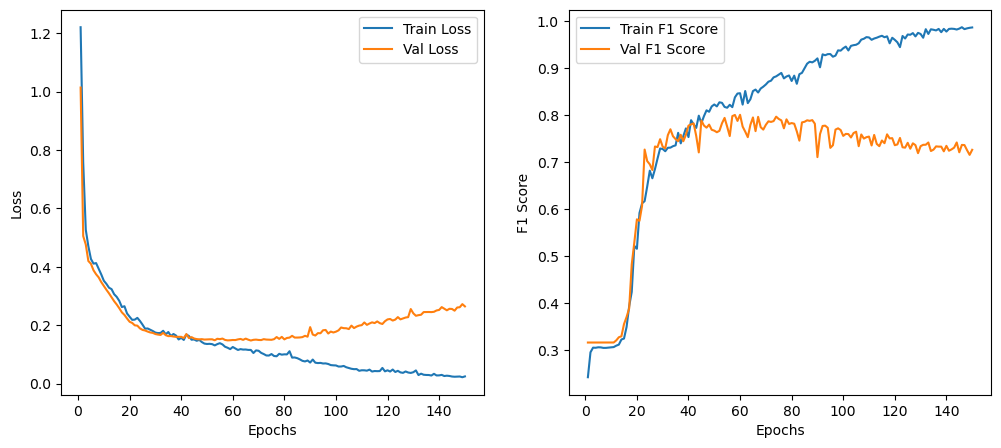

In [13]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()